In [1]:
from __future__ import print_function

import sys
import os

#sys.path.append('UrbanCNN/');
#sys.path.append('srimmele/');
#sys.path.append('ecbm4040/');
import tensorflow as tf

from matplotlib.pyplot import imshow, plot, title, subplots


from srimmele.data_utils import getCityImages
from UrbanCNN.utils import generator_from_file
import numpy as np

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
city = 'berlin, de'
if not os.path.exists('imagery/' + city):
    getCityImages(city)
else:
    print ('Image files already extracted')

Image files already extracted


[Image augmentation in original paper](https://github.com/adrianalbert/urban-environments/blob/master/land-use-classification/Finetuning%20on%20Urban%20Atlas%20data.ipynb)

In [24]:
all_classes = '''Agricultural + Semi-natural areas + Wetlands
Airports
Construction sites
Continuous Urban Fabric (S.L. > 80%)
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
Fast transit roads and associated land
Forests
Green urban areas
Industrial, commercial, public, military and private units
Isolated Structures
Land without current use
Mineral extraction and dump sites
Other roads and associated land
Port areas
Railways and associated land
Sports and leisure facilities
Water bodies'''.split("\n")

include_classes = ["Green urban areas", 
                       "Airports",
                       "Forests",
                       "Agricultural + Semi-natural areas + Wetlands",
                       # "Railways and associated land",
                       "High Density Urban Fabric", 
                        #"Mineral extraction and dump sites",
                       "Medium Density Urban Fabric", 
                       "Low Density Urban Fabric",
                       "Water bodies",
                       "Sports and leisure facilities",
                       "Industrial, commercial, public, military and private units"]


classes = include_classes
print(len(classes))

class2label = {c:i for i,c in enumerate(classes)}
label2class = {i:c for i,c in enumerate(classes)}
class_weights = {c:1 for c in label2class.keys()}

10


In [53]:
from keras.preprocessing.image import ImageDataGenerator


#this is the augmentation configuration the author's use for training
train_augmenter = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.10,
        zoom_range=[1,1.2],
        vertical_flip=True,
        rotation_range=15,
        horizontal_flip=True)

test_augmenter = ImageDataGenerator(rescale=1./255)

In [59]:
train_generator      = generator_from_file('data/train.csv', image_generator= train_augmenter, balance=1, \
                            batch_size = 50, seed=26, new_img_shape= (224,224), \
                            class_dict=class2label, shuffle=True, channels="RGB",
                            downsample=True, crop= 42, batch_type = 'training', one_hot = False)

validation_generator = generator_from_file('data/train.csv', image_generator= test_augmenter, balance=1, \
                        batch_size = 50, seed=26, new_img_shape= (224,224), \
                        class_dict=class2label, shuffle=True, channels="RGB",
                        downsample=False, crop = 42, batch_type = 'validation', one_hot = False)


19601 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


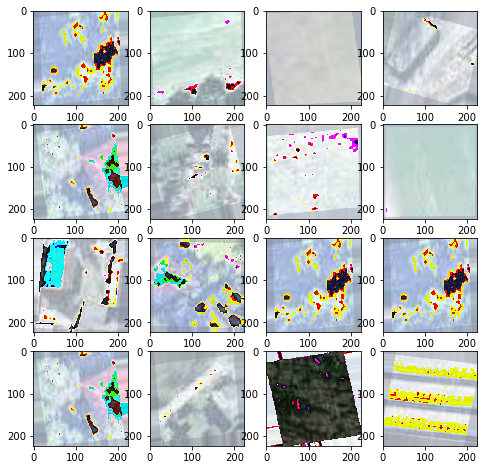

In [55]:
from numpy import random

r = 4
f, axarr = subplots(r, r, figsize=(8,8))
test = next(train_generator)

for i in range(r):
    for j in range(r):

        img = test[0][random.randint(0,50),:,:,:] 
        axarr[i][j].imshow(img)
        #title(label2class[test[1][0]])


In [ ]:
## construction sites are largely inaccurate

test = next(train_generator)
image =imshow(test[0][0,:,:,:])
test[1][0]
title(label2class[test[1][0]])


In [ ]:
test = next(validation_generator)
image =imshow(test[0][1,:,:,:])
title(label2class[test[1][1]])


In [56]:
conv_feat_dict = {}

conv_feat_dict[0] = [64 , 64]
conv_feat_dict[1] = [128 , 128]
conv_feat_dict[2] = [256 ,256, 256]
conv_feat_dict[3] = [512 , 512, 512]
conv_feat_dict[4] = [512 , 512, 512]

conv_kernel_dict = dict(keys = conv_feat_dict.keys())

conv_kernel_dict[0] = [3] * 2
conv_kernel_dict[1] = [3] * 2
conv_kernel_dict[2] = [3] * 3
conv_kernel_dict[3] = [3] * 3
conv_kernel_dict[4] = [3] * 3

pooling_size_dict = dict(keys = conv_feat_dict.keys())

pooling_size_dict[0] = [2] * 2
pooling_size_dict[1] = [2] * 2
pooling_size_dict[2] = [2] * 3
pooling_size_dict[3] = [2] * 3 
pooling_size_dict[4] = [2] * 3

fc_units = [4096, 4096]


In [ ]:
from srimmele.Imagenet_classifiers import training

tf.reset_default_graph()

training(train_generator, validation_generator,
             conv_feat_dict = conv_feat_dict,
             fc_units = fc_units,
             conv_kernel_dict = conv_kernel_dict,
             pooling_size_dict = pooling_size_dict,
             img_size = 224,
             l2_norm=0.0,
             seed=27,
             batch_size = 50,
             learning_rate= 0.1,
             lr_decay = 2.0,
             epoch=20,
             samples_per_epoch = 2000,
             verbose=False,
             pre_trained_model=None)

Tensor("inputs/Placeholder_2:0", dtype=float32)
assigned :conv_layer_11/conv_kernel_11
assigned :conv_layer_0/conv_kernel_0
assigned :conv_layer_3/conv_kernel_3
assigned :conv_layer_11/conv_bias/conv_bias_11
assigned :conv_layer_10/conv_bias/conv_bias_10
assigned :conv_layer_0/conv_bias/conv_bias_0
assigned :conv_layer_14/conv_kernel_14
assigned :conv_layer_6/conv_kernel_6
assigned :conv_layer_1/conv_bias/conv_bias_1
assigned :conv_layer_15/conv_bias/conv_bias_15
assigned :conv_layer_12/conv_kernel_12
assigned :conv_layer_7/conv_kernel_7
assigned :conv_layer_3/conv_bias/conv_bias_3
assigned :conv_layer_6/conv_bias/conv_bias_6
assigned :conv_layer_15/conv_kernel_15
assigned :conv_layer_10/conv_kernel_10
assigned :conv_layer_16/conv_bias/conv_bias_16
assigned :conv_layer_16/conv_kernel_16
assigned :conv_layer_12/conv_bias/conv_bias_12
assigned :conv_layer_8/conv_bias/conv_bias_8
assigned :conv_layer_7/conv_bias/conv_bias_7
assigned :conv_layer_8/conv_kernel_8
assigned :conv_layer_14/conv

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2827 total records
Best validation accuracy! iteration:10 accuracy: 6.0%
Best validation accuracy! iteration:20 accuracy: 12.0%
Best validation accuracy! iteration:30 accuracy: 20.0%
Best validation accuracy! iteration:40 accuracy: 22.0%
epoch 2 
Best validation accuracy! iteration:50 accuracy: 24.0%
Best validation accuracy! iteration:80 accuracy: 26.0%
epoch 3 
epoch 4 
epoch 5 
Best validation accuracy! iteration:180 accuracy: 32.0%
epoch 6 
epoch 7 
epoch 8 
epoch 9 


In [ ]:
# ADAM VGG16_1513454525

## DO

* add accuracy to tensorboard variables
* ~change padding back to SAME~
* train new model on 112/122 data?
* do madrid
* back to AdaDelta?

## DID
* try AdaDelta
* downsample to 112
* kernel size 1/2/3



VGG16_1513200379
VGG16_1513200871 

Share with TAs : VGG16_1513203220


## VGG16_1513313819,  94%
* 80 epochs
* 0 norm
* 0.1 learning rate
* kernel 2 


## VGG16_1513296320
* batch size 50
* 40 epochs
* kernel size 2



# Wrong validation dims

## Best: VGG16_1513216839, 90% val
* batch size 50
* 40 epochs
* kernel size 2

## Best: VGG16_1513212753 , 64% val
* batch size 50
* 50 epochs
* kernel size 1

## Notes:

Keras Convolution2d defaults:
* padding = 'valid' , but author adds 0padding layer to compensate. 
* bias initialized to 0
* glorot uniform kernel init

VGG16 pretrain: 
http://www.cs.toronto.edu/~frossard/post/vgg16/

see here for weights and code


### Attempted parameter tuning
* learning rate vary from .1 (paper) down to 1e-4 (original VGG16)
* LR Decay from 2-10
* Penalty from 0 to 5e-2 (original VGG)
* Kernel size 2 and 3
* batch size 50-100 , 100 (paper batch count) maxes out memory
* Crop image following paper specs vs. original image.
* Adadelta and Adam optimizers



/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


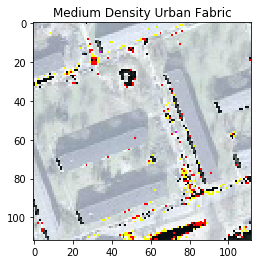

In [29]:
test_generator = generator_from_file('data/test.csv', image_generator= None, balance=False, \
                        batch_size = 200, seed=26, new_img_shape= (112,112), \
                        class_dict=None, shuffle=True, channels="RGB",
                        downsample=False, crop = None, batch_type = None, one_hot = False)

test_set = next(test_generator)

image =imshow(test_set[0][1,:,:,:])
title(label2class[test_set[1][1]])

In [61]:
### Testing code 
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model/VGG16_1513385468.meta')
    saver.restore(sess, tf.train.latest_checkpoint('model/'))

    graph = tf.get_default_graph()
    
    tf_input = graph.get_operations()[0].name+":0"
    x = graph.get_tensor_by_name(tf_input)
    print(x)
    
    tf_output = "fc_layer_2/Add:0"
    y = graph.get_tensor_by_name(tf_output)
    print(y)
    
    for i in range(10):
        test_set = next(train_generator)
        X_test =  test_set[0]


        prediction=tf.argmax(y,1)
        y_out = prediction.eval(feed_dict={x: X_test  })
        print(prediction)
        print((y_out == test_set[1]).mean())

INFO:tensorflow:Restoring parameters from model/VGG16_1513385468
Tensor("inputs/Placeholder:0", shape=(?, 112, 112, 3), dtype=float32)
Tensor("fc_layer_2/Add:0", shape=(?, 10), dtype=float32)
19601 total records


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Tensor("ArgMax:0", shape=(?,), dtype=int64)
0.48
Tensor("ArgMax_1:0", shape=(?,), dtype=int64)
0.515
Tensor("ArgMax_2:0", shape=(?,), dtype=int64)
0.455
Tensor("ArgMax_3:0", shape=(?,), dtype=int64)
0.515
Tensor("ArgMax_4:0", shape=(?,), dtype=int64)
0.48
Tensor("ArgMax_5:0", shape=(?,), dtype=int64)
0.5
Tensor("ArgMax_6:0", shape=(?,), dtype=int64)
0.495
Tensor("ArgMax_7:0", shape=(?,), dtype=int64)
0.525
Tensor("ArgMax_8:0", shape=(?,), dtype=int64)
0.515
Tensor("ArgMax_9:0", shape=(?,), dtype=int64)
0.505


In [43]:
[label2class[i] for i in y_out]

['Low Density Urban Fabric',
 'High Density Urban Fabric',
 'Low Density Urban Fabric',
 'Water bodies',
 'Water bodies',
 'Water bodies',
 'High Density Urban Fabric',
 'Low Density Urban Fabric',
 'Green urban areas',
 'Low Density Urban Fabric',
 'Airports',
 'Water bodies',
 'Airports',
 'Airports',
 'High Density Urban Fabric',
 'Low Density Urban Fabric',
 'Green urban areas',
 'Green urban areas',
 'Water bodies',
 'Low Density Urban Fabric',
 'Water bodies',
 'High Density Urban Fabric',
 'Low Density Urban Fabric',
 'Green urban areas',
 'Low Density Urban Fabric',
 'High Density Urban Fabric',
 'Low Density Urban Fabric',
 'Water bodies',
 'High Density Urban Fabric',
 'Low Density Urban Fabric',
 'Airports',
 'Airports',
 'Water bodies',
 'Green urban areas',
 'Low Density Urban Fabric',
 'Airports',
 'Airports',
 'Low Density Urban Fabric',
 'Low Density Urban Fabric',
 'High Density Urban Fabric',
 'Green urban areas',
 'Water bodies',
 'Green urban areas',
 'Low Density U